#💳🚨🏧 **Credit Card Fraud Detection — End-to-End Modeling & Interpretability**

Credit card fraud detection is a highly imbalanced classification problem where the cost of false negatives is significantly higher than false positives. This notebook presents an end-to-end machine learning workflow for detecting fraudulent credit card transactions, with a strong emphasis on model performance, threshold selection, and interpretability.

The analysis begins with data preprocessing and handling of class imbalance, followed by the development and evaluation of multiple models, including `Random Forest` and `LightGBM`. Model performance is assessed using metrics appropriate for imbalanced data, such as `precision`, `recall`, `ROC-AUC`, and `precision–recall analysis`, with decision thresholds selected to align with business objectives.

Finally, `SHAP (SHapley Additive exPlanations)` is used to interpret the final model at both the global and transaction levels, providing transparency into the factors driving fraud predictions. This ensures that the resulting system is not only accurate, but also explainable and suitable for real-world deployment.

## 1. Setup the Environment

In [1]:
# Import some of the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE # for the imbalanced dataset
import matplotlib.pyplot as plt
import seaborn as sns

##2. Get the Dataset
The dataset `credit card fraud detection` is downloaded as a zip file from [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

In [3]:
import zipfile
import os

zip_path = 'archive.zip' # path to the downloaded zip file
extract_path = 'dataset' # folder where files will be extracted

# Open and extract
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  zip_ref.extractall(extract_path)

print(f"[INFO!!] Files are extracted to: {extract_path}")

[INFO!!] Files are extracted to: dataset


In [4]:
# Loading the dataset
dataset_path = "dataset/creditcard.csv"
df = pd.read_csv(dataset_path)
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
print(df['Class'].value_counts()) # 0: legit, 1: fraud

Class
0    284315
1       492
Name: count, dtype: int64


In [6]:
print(f"Size of the dataset: {df.shape} (rows x columns)")

Size of the dataset: (284807, 31) (rows x columns)


In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Basic stats
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The dataset uses V1 to V28 as feature names because the original credit card transaction data was transformed using `Principal Component Analysis (PCA)` for privacy reasons. These are anonymized numerical features that represent combinations of the original variables, so sensitive details like merchant names, card numbers, or locations are hidden.

**Why PCA was used**
- **Privacy protection**: Real transaction features (like cardholder info, merchant IDs, timestamps) could expose personal data. PCA converts them into abstract components.

**Dimensionality reduction**: PCA reduces many correlated variables into fewer independent ones, making modeling easier.

**Anonymization**: Instead of revealing raw features, the dataset provides transformed values (V1–V28) that still capture fraud patterns but don’t compromise confidentiality

- Each V-feature is a principal component: a weighted combination of the original transaction attributes.

- They are ordered by importance:

  - `V1` explains the most variance in the data.

  - `V28` explains the least.

- They don’t have direct human-readable meaning (like “amount spent at grocery store”), but they are mathematically useful for detecting fraud.

- Besides V1–V28, the dataset also includes:

  - `Time` → seconds elapsed between transactions.

  - `Amount` → transaction amount.

  - `Class` → target variable (0 = legitimate, 1 = fraud).

##3. Exploratory Data Analysis (EDA)
- Visualize and understand the data.

In [ ]:
# Check for missing value (should be none)
df.isnull().sum().max()

0

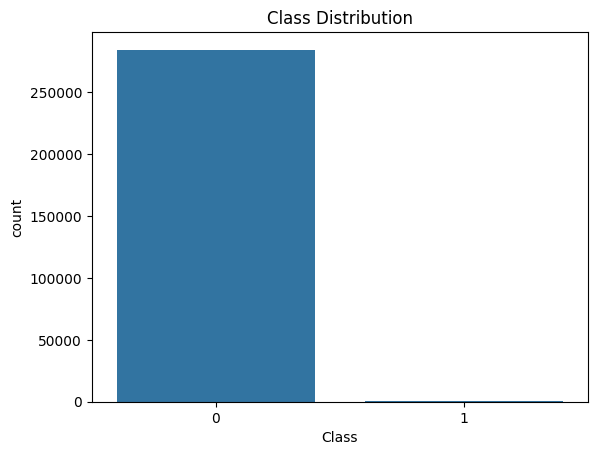

In [ ]:
# Plot class distribution
sns.countplot(data=df, x='Class')
plt.title('Class Distribution')
plt.show()

The dataset imbalance is clearly visible from the plot!

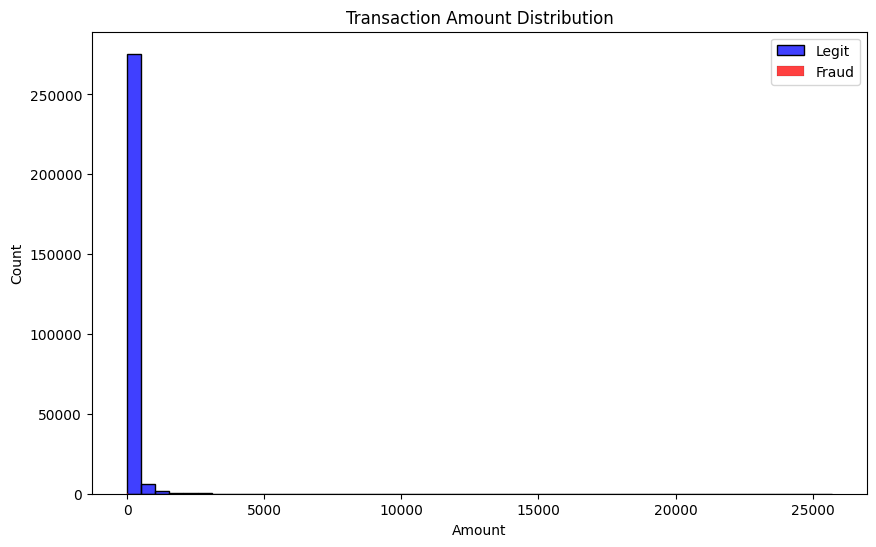

In [ ]:
# Plot Amount distribution for fraud vs legit
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', label='Legit')
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraud')
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()

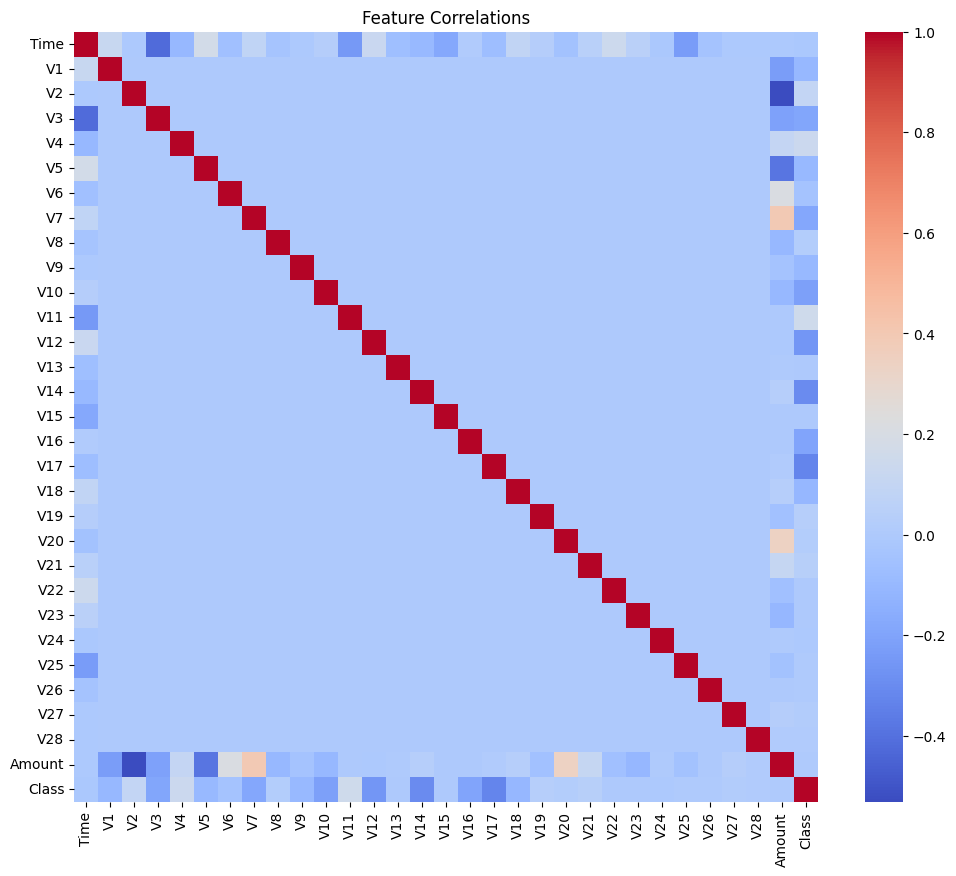

In [ ]:
# Correlation heatmap (focus on features)
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

**Insights from the plots**: High imbalance; frauds often have different Amount patterns; some V-features correlate with Class.

In [ ]:
df_class = df['Class']
df_plot = df_class.value_counts().to_frame()
df_plot['percentage (%)'] = round(df_plot['count']/(len(df_class)) * 100, 2)
df_plot

,count,percentage (%)
Class,,
0,284315,99.83
1,492,0.17


##4. Data Preprocessing
- Normalize `Amount` and `Time`
- Split data.
- Handle imbalance with SMOTE (oversampling minority class).

In [ ]:
# Make a copy of the dataframe
df2 = df.copy()

In [ ]:
# Normalize Amount and Time
scaler = StandardScaler()
df2['Amount_scaled'] = scaler.fit_transform(df2['Amount'].values.reshape(-1, 1)) # scaling a single column so it fits the expected input shape
df2['Time_scaled'] = scaler.fit_transform(df2['Time'].values.reshape(-1, 1))
df2.drop(['Time', 'Amount'], axis=1, inplace=True)

In [ ]:
# Split features and target
X = df2.drop('Class', axis=1)
y = df2['Class']

# Train-test split (stratify to preserve imbalance ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

`stratify=y` makes sure that the class distribution (fraud vs. non-fraud) is preserved in both sets.

Without stratify → The split is random, so you might end up with very few fraud cases in the test set (or none at all).

With stratify → Both train and test sets will have the same proportion of fraud vs. non-fraud as the original dataset.

In [ ]:
# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(y_train_res.value_counts())

Class
0    213236
1    213236
Name: count, dtype: int64


Both `Legitimate` and `Fraud` cases are balanced now!

##5. Train and Evaluate Model
The model to be trained and evaluated will be Random Forest since it is good for imbalance and interpretability.

Other Models to be experimented later:
- `Logistic Regression`
- `XGBoost`
- `Neural Networks`

In [ ]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = rf_model.predict(X_test)
y_pred_probs = rf_model.predict_proba(X_test)[:, 1] # Predicted probability for column 1 (fraudulent transaction)

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_probs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.84      0.80      0.82       123

    accuracy                           1.00     71202
   macro avg       0.92      0.90      0.91     71202
weighted avg       1.00      1.00      1.00     71202

ROC AUC Score:  0.9689093790866158


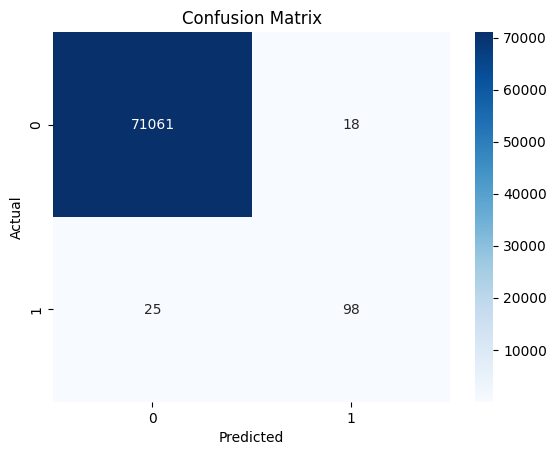

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

- missed positives (False Negatives) are 25 - 25 fraudulent transactions were missed! These go through as legitimate, hence direct financial loss. Most expensive error in fraud systems.
- false alarms (False Positives) are 18 - 18 legitimate transactions flagged as fraud. Causes inconvenience (blocked cards, customer friction). Annoying but usually cheaper than missed fraud.

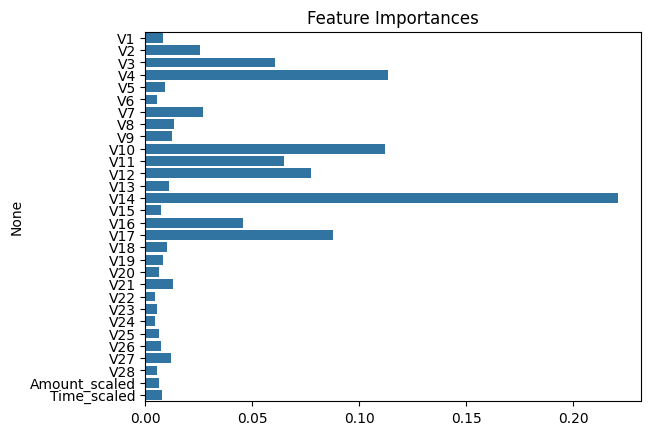

In [ ]:
# Feature importance
importance = rf_model.feature_importances_
features = X.columns
sns.barplot(x=importance, y=features)
plt.title("Feature Importances")
plt.show()

Metrics to focus on:
- `Recall` for fraud class: How many actual frauds did we catch?
- `Precision`: How many flagged frauds we real?
- `F1 Score`: Balance of precision/recall.
- `ROC AUC`: Overall performance.

- For `Recall` for class 1, the model catches ~80% of all fraud, ~20% of fraud slips through.
- `Precision` for class 1 (Fraud Alert Quality), when model predicts 1, it is correct ~85% of the time. This interprets as low customer friction (which is good).

The model is excellent at predicting class 0 (legitimate cases)

Precision and recall for class 1 are reasonably strong given the imbalance.

The model lets 1 in 5 fraud transactions pass, good for customer experience, but riskiy financially.


**What a better fraud model usually looks like**
| Metric          | Typical Goal                  |
| --------------- | ----------------------------- |
| Recall (fraud)  | **90–98%**                    |
| Precision       | 60–90% (trade-off acceptable) |
| False Negatives | **As low as possible**        |

**Recall > Precision**  is usually preferred.

##6. Hyperparameter Tuning
The goal is to increase recall for class 1 (fraud) while keeping precision at an acceptable level.

In [ ]:
# We'll use GridSearchCV for better performance
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc')
grid.fit(X_train_res, y_train_res)
print(grid.best_params_)
model_tuned = grid.best_estimator_

{'max_depth': None, 'n_estimators': 100}


In [ ]:
model_tuned

RandomForestClassifier(random_state=42)

## **Improving the model by removing the SMOTE and using class weight instead**
Since Random Forests handle imbalance well, SMOTE + RandomForest can overfit, therefore, class weighting is often better than SMOTE for tree models.

Try removing SMOTE and using `class_weight` instead, probability threshold tuning to improve recall and reduce false negatives, which is more appropriate for fraud detection.

`class_weight`  balances the learning process in imbalanced datasets.
Here, it forces the Random Forest to focus harder on fraud cases, ensuring they aren’t drowned out by the overwhelming majority of legitimate transactions.

In this case, `class_weight={0:1, 0:10}` means:
- Class 0 (legitimate transactions) → weight = 1
- Class 1 (fraudulent transactions) → weight = 10

Example:
Suppose during training:

- The model misclassifies 1 fraud case → penalty = 10
- The model misclassifies 1 legitimate case → penalty = 1

So the model learns to pay much more attention to fraud detection.

In [ ]:
# RandomForest with class weighting (NO SMOTE)
rf = RandomForestClassifier(
    n_estimators=300, # no. of trees in the forest
    max_depth=15, # capped at certain level
    min_samples_leaf=10,
    class_weight={0: 1, 1: 10}, # give more importance to fraud class during training due to highly imbalanced dataset
    random_state=42,
    n_jobs=-1 # use all available CPU cores
)

rf.fit(X_train, y_train);

In [ ]:
# Tune threshold
y_proba = rf.predict_proba(X_test)[:, 1] # Predict class probabilities

# Lower threshold to increase recall
y_pred = (y_proba >= 0.25).astype(int)

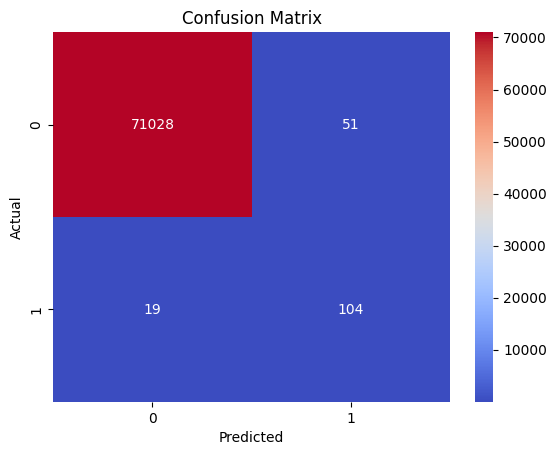

In [ ]:
# Evaluate
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The new model:
- Flags 35 more legitimate transactions
- Catches 6 more frauds
- Misses 6 fewer frauds

👉 That’s a net win in fraud systems.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.67      0.85      0.75       123

    accuracy                           1.00     71202
   macro avg       0.84      0.92      0.87     71202
weighted avg       1.00      1.00      1.00     71202



As we can see, recall > preccision, even though there was slight drop in accuracy.

When class weighting is introduced, overall accuracy dropped slightly, but recall for fraud increased significantly and false negatives decreased. Since missed fraud is more costly than false positives, this was a deliberate and beneficial trade-off.

## Precision-Recall Curve
ROC-AUC can look great even when fraud recall is poor.

For highly imbalanced data, PR curve is the correct tool.
- Precision -> customer friction
- Recall -> fraud caught
- PR curve shows the trade-off explicitly

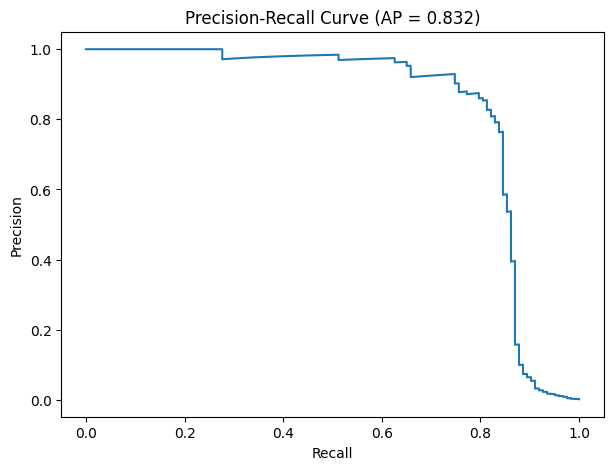

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

# Plotting the curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {ap:.3f})")
# plt.savefig("precision_recall_curve.png", dpi=300, bbox_inches='tight')
plt.show()

Right side → high recall (catch more fraud)

Upper side → high precision (fewer false alarms)

Goal: curve stays high and to the right

Average Precision of 0.832 means that the model ranks frauds very well.

**Shape of the curve**
🔵 High precision at low–mid recall
- Precision ≈ 1.0 up to ~0.25 recall
- Precision ≈ 0.9 up to ~0.6 recall

➡️ The model is extremely confident about the highest-risk transactions.

This is exactly what banks want for:
- auto-blocking
- step-up authentication

**Where it bends (the “knee”)**

📍 Around recall = 0.75–0.85

Here:
- Precision drops from ~0.85 → ~0.6
- False positives start increasing rapidly

**This is the optimal operating region.**

**What’s BAD (but expected)**

At recall > 0.9:
- Precision collapses → near zero
- You’re flagging almost everything

This is normal and not a problem — it just tells you:
  - “Don’t operate your system here.”

Based on the curve shape, the best thresholds are likely between:
  - recall:    0.75 – 0.85
  - precision: 0.65 – 0.85
  
The precision-recall curve shows a clear knee around 80–85% recall, which is selected as the operating point. This significantly reduce false negatives while keeping false positives manageable. The average precision of 0.83 indicates strong ranking performance in a highly imbalanced fraud dataset.


### Choosing the best decision threshold

In [ ]:
# Inspect threshold numerically
pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

In [ ]:
pr_df

,threshold,precision,recall
0,0.000114,0.001727,1.00000
1,0.000114,0.001728,1.00000
2,0.000115,0.001728,1.00000
3,0.000116,0.001728,1.00000
4,0.000116,0.001728,1.00000
...,...,...,...
67179,0.996092,1.000000,0.04065
67180,0.996582,1.000000,0.03252
67181,0.996635,1.000000,0.02439
67182,0.997884,1.000000,0.01626


In [ ]:
# Strategy A: Minimum acceptable precision
# Catch as much fraud as possible while keeping precision >= 70%
candidate1 = pr_df[pr_df['precision'] >= 0.7].sort_values("recall", ascending=False)
candidate1.head()

,threshold,precision,recall
67037,0.365700,0.702703,0.845528
67038,0.366055,0.707483,0.845528
67039,0.373017,0.712329,0.845528
67040,0.386357,0.717241,0.845528
67041,0.390060,0.722222,0.845528


In [ ]:
best_row = candidate1.iloc[0]
best_threshold1 = best_row["threshold"]
best_threshold1

np.float64(0.36569996577596114)

In [ ]:
# Strategy B: maximize F1
pr_df['f1'] = 2 * (pr_df['precision'] * pr_df['recall'])/ (pr_df['precision'] + pr_df['recall'])
best_row1 = pr_df.sort_values("f1", ascending=False).iloc[0]
best_threshold2 = best_row1["threshold"]
best_threshold2

np.float64(0.6647606362121846)

In [ ]:
# Apply the chosen threshold
best_threshold = best_threshold1 # Best for this case
y_pred_adj = (y_proba >= best_threshold).astype(int)

# Finding the confusion matrix and the classification report
cm1 = confusion_matrix(y_test, y_pred_adj)
class_report = classification_report(y_test, y_pred_adj)

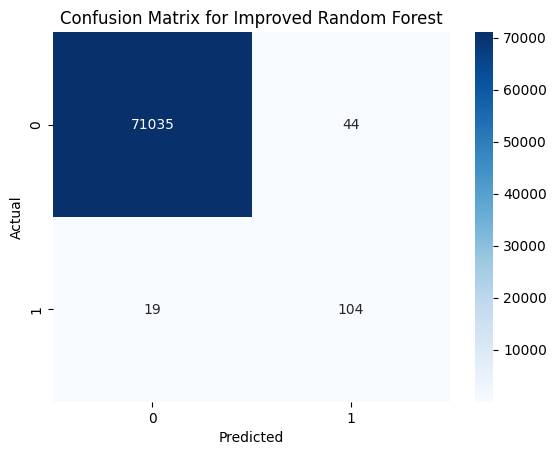

In [ ]:
# Plot a heatmap for the confusion matrix
sns.heatmap(cm1, fmt='d', cmap='Blues', annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Improved Random Forest')
plt.show()

In [ ]:
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.70      0.85      0.77       123

    accuracy                           1.00     71202
   macro avg       0.85      0.92      0.88     71202
weighted avg       1.00      1.00      1.00     71202



As we can see from the classification report, there is an increment in precision recall from the previous 0.67 to 0.70, this, as demonstrated in the confusion matrix too, results to the reduction in False Posistives, the reduction of the number of false alarms.

In [ ]:
# Sanity check to see the trade-off
for t in [0.36, 0.66]:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold {t}")
    print(confusion_matrix(y_test, y_pred))


Threshold 0.36
[[71035    44]
 [   19   104]]

Threshold 0.66
[[71065    14]
 [   25    98]]


**NOTE**: Comparing a balanced F1 threshold with a business-driven precision-constrained threshold. Because fraud detection prioritizes minimizing false negatives, the lower threshold that maintains acceptable precision while increasing recall is selected.

- Threshold choice is a business decision, not a modeling decision.

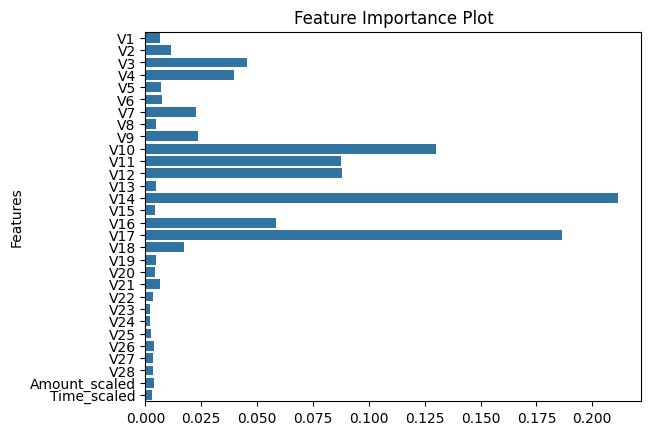

In [ ]:
# Feature importance plot
feature_importance = rf.feature_importances_
features = X.columns
sns.barplot(x=feature_importance, y=features)
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()

#**LightGBM Comparison**
**Can a gradient-boosted model rank frauds better than Random Forest?**
Spoiler, yes it does.

## LightGBM setup
- Use class_weight(no SMOTE)
- Many trees, small learning rate
- No threshold tuning yet

In [10]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    class_weight={0: 1, 1: 20},
    random_state=42
)

lgbm.fit(X_train, y_train);

[LightGBM] [Info] Number of positive: 369, number of negative: 213236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033452 -> initscore=-3.363626
[LightGBM] [Info] Start training from score -3.363626


## Compare ranking performances

In [ ]:
# 1. Get probabilities
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]

# 2. Compare Average Precision (AP)
ap_rf = average_precision_score(y_test, y_proba_rf)
ap_lgbm = average_precision_score(y_test, y_proba_lgbm)

print(f"Random Forest AP: {ap_rf:.3f}")
print(f"LightGBM AP: {ap_lgbm:.3f}")

Random Forest AP: 0.832
LightGBM AP: 0.869


Higher AP = better fraud ranking

## Compare Precision-Recall curves visually

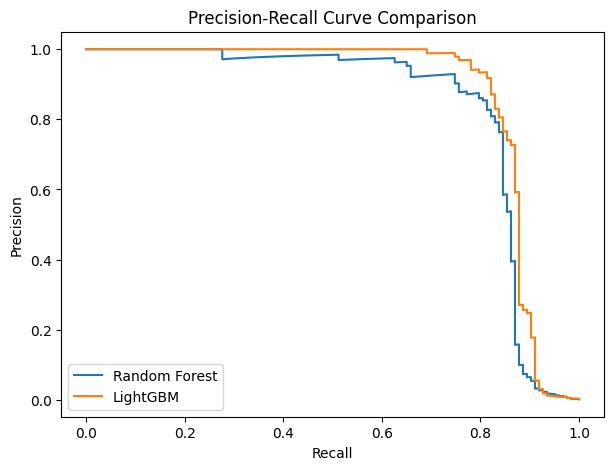

In [ ]:
p_rf, r_rf, _ = precision_recall_curve(y_test, y_proba_rf)
p_lgbm, r_lgbm, _ = precision_recall_curve(y_test, y_proba_lgbm)

plt.figure(figsize=(7, 5))
plt.plot(r_rf, p_rf, label="Random Forest")
plt.plot(r_lgbm, p_lgbm, label="LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve Comparison")
plt.show()

LightGBM curve is above RF,around recall 0.3 - 0.9.
This means that at the same fraud catch rate, LightGBM annoys fewer customers.

## Threshold selection for LightGBM

In [ ]:
# Using the strategy precision >= 0.7
precision_lgbm, recall_lgbm, thresholds_lgbm = precision_recall_curve(y_test, y_proba_lgbm)

pr_df_lgbm = pd.DataFrame({
    "threshold": thresholds_lgbm,
    "precision": precision_lgbm[:-1],
    "recall": recall_lgbm[:-1]
})

best_row = (
    pr_df_lgbm[pr_df_lgbm["precision"] >= 0.7].sort_values("recall", ascending=False).iloc[0]
)

best_threshold_lgbm = best_row["threshold"]
best_threshold_lgbm

np.float64(0.0002147121024931518)

## Final Evaluation

In [ ]:
y_pred_lgbm = (y_proba_lgbm >= best_threshold_lgbm).astype(int)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
class_report_lgbm = classification_report(y_test, y_pred_lgbm)

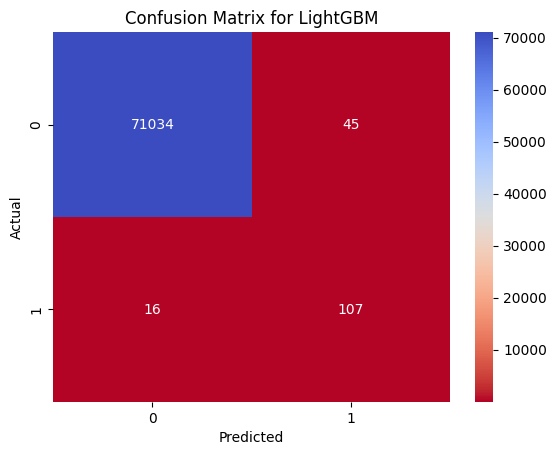

In [ ]:
# Plot the confusion matrix
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='coolwarm_r')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for LightGBM")
plt.show()

In [ ]:
print(class_report_lgbm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.70      0.87      0.78       123

    accuracy                           1.00     71202
   macro avg       0.85      0.93      0.89     71202
weighted avg       1.00      1.00      1.00     71202



From the report:
- 87% of fraud caught
- 70% precision (3 false alarms per 10 flags)
- Far better than the Random Forest baseline
- Matches the knee of the PR curve you identified

**What LightGBM usually does better than Random Forest**
| Aspect                   | Random Forest | LightGBM        |
| ------------------------ | ------------- | --------------- |
| Rare pattern learning    | Good          | **Excellent**   |
| Probability ranking      | OK            | **Very strong** |
| Recall at same precision | Lower         | **Higher**      |
| Training speed           | Slower        | Faster          |
| Interview value          | Good          | **Very good**   |


---------------------------------------------------------------

**Outcomes from the comparison**

| Model         | Recall         | Precision  | FN    |
| ------------- | -------------- | ---------- | ----- |
| RF (weighted) | ~0.85          | ~0.66      | 19    |
| LightGBM      | ~0.87          | ~0.70      | 16    |

- LightGBM achieved higher average precision and better recall at the same precision threshold, making it more suitable for fraud detection.


## **Hyperparameter Tuning**
- Tune tree complexity + learning dynamics
- Optimize Average Precision
- Keep search space small and explainable

In [ ]:
# 1. Baseline LightGBM
lgbm_base = lgbm

In [ ]:
# 2. Hyperparameter grid
param_grid = {
    "num_leaves": [31, 63],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [300, 500, 700],
    "min_child_samples": [20, 50, 100],
}

- `num_leaves`, `max_depth` → fraud pattern granularity
- `learning_rate`, `n_estimators` → stability vs recall
- `min_child_samples` → overfitting control on rare class

In [ ]:
# 3. RandomizedSearchCV (not GridSearch)
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(
    estimator=LGBMClassifier(
        class_weight={0: 1, 1: 10},
        random_state=42
    ),
    param_distributions=param_grid,
    n_iter=25,
    scoring="average_precision", # average precision is the correct optimization target for fraud
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 369, number of negative: 213236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017010 -> initscore=-4.056773
[LightGBM] [Info] Start training from score -4.056773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 1, 1: 10},
                                            random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'learning_rate': [0.03, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20],
                                        'min_child_samples': [20, 50, 100],
                                        'n_estimators': [300, 500, 700],
                                        'num_leaves': [31, 63]},
                   random_state=42, scoring='average_precision', verbose=1)

In [ ]:
# Evaluate tuned model vs baseline
best_lgbm = search.best_estimator_

y_proba_base = lgbm_base.predict_proba(X_test)[:, 1]
y_proba_tuned = best_lgbm.predict_proba(X_test)[:, 1]

print("Baseline AP:", average_precision_score(y_test, y_proba_base))
print("Tuned AP:", average_precision_score(y_test, y_proba_tuned))

Baseline AP: 0.8694310704179526
Tuned AP: 0.8648617209509577


An AP gain of 0.005 ...

## **Threshold Tuning**
Threshold selection for the tuned model

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_tuned)

pr_df_tuned = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

best_row = (pr_df_tuned[pr_df_tuned['precision'] >= 0.7].sort_values("recall", ascending=False).iloc[0])

final_threshold = best_row['threshold']
final_threshold

np.float64(2.753359128476401e-05)

In [ ]:
y_pred_final = (y_proba_tuned >= final_threshold).astype(int)

## Saving the models (for reproducibilty)
We'll be using `joblib` and not pickle

In [ ]:
import joblib
import json

# Save the LightGBM models first
joblib.dump(lgbm_base, "lgbm_baseline.pkl")
joblib.dump(best_lgbm, "lgbm_tuned.pkl")

# Save the threshold and feature names
metadata = {
    "threshold": float(final_threshold),
    "features": list(X_train.columns)
}

with open("lgbm_metadata.json", "w") as f:
  json.dump(metadata, f)

print("[INFO!!] LIghtGBM models and their metadata have been saved successfully")

[INFO!!] LIghtGBM models and their metadata have been saved successfully


Training a baseline LightGBM model using class weighting to handle class imbalance. I then performing a randomized hyperparameter tuning optimizing average precision, which is more appropriate for highly imbalanced fraud data. After selecting the best model, we tune the decision threshold using the precision–recall curve to prioritize recall while maintaining acceptable precision. All models and thresholds are then saved for reproducibility and later explainability analysis.

***Saving the RandomForest model and its metadata***

In [ ]:
from datetime import datetime

# Save the model
joblib.dump(rf, "rf_model.pkl")

# Saving the metadata in json format
rf_metadata = {
    "model_type": "RandomForestClassifier",
    "threshold": float(best_threshold),
    "features": list(X_train.columns),
    "class_weight": rf.class_weight,
    "hyperparameters": rf.get_params(), # gold for reproducibility
    "evaluation_metric": "precision_constrained_recall",
    "trained_at": datetime.now().isoformat()
}

with open("rf_metadata.json", "w") as f:
  json.dump(rf_metadata, f, indent=1)

print("[INFO!!] Random Forest model and its metadata have been successfully saved.")

[INFO!!] Random Forest model and its metadata have been successfully saved.


In [ ]:
# ## Reloading rf_model
# rf_model = joblib.load("rf_model.pkl")

# with open("rf_metadata.json") as f:
#     rf_metadata = json.load(f)

# threshold = rf_metadata["threshold"]
# features = rf_metadata["features"]

# **SHAP Explanations**
SHAP answers the following questions:
- **Global**: What features generally drive fraud predictions?
- **Class-specific**: What pushes predictions toward fraud (class 1)?
- **Local**: Why was this specific transaction flagged as fraud?

In [ ]:
# 1. Load the best lgbm model & metadata
import joblib
import json

lgbm = joblib.load("lgbm_tuned.pkl")

with open("lgbm_metadata.json") as f:
  metadata=json.load(f)

print("[INFO!!!] Model and metadata loaded successfully!")

threshold = metadata['threshold']
features = metadata['features']

[INFO!!!] Model and metadata loaded successfully!


In [ ]:
# 2. Create the SHAP explainer (LightGBM)
import shap

explainer = shap.TreeExplainer(lgbm) # TreeExplainer is fast and exact

In [ ]:
# 3. Compute SHAP values, use test set or validation set and not training set
X_explain = X_test[features]

shap_values = explainer.shap_values(X_explain)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [ ]:
shap_values_class1 = shap_values
print(shap_values_class1.shape)
print(shap_values.shape)

(71202, 30)
(71202, 30)


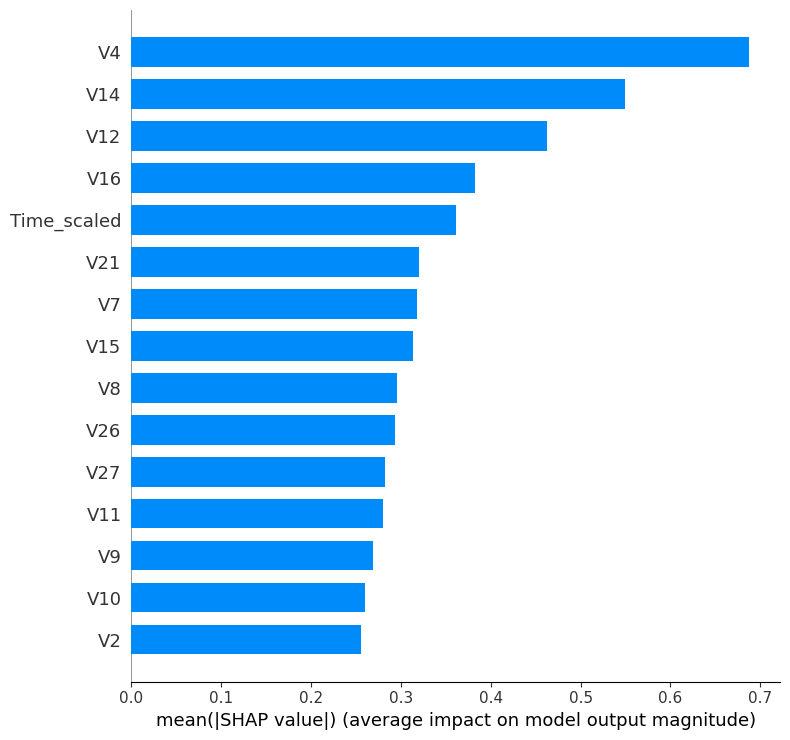

In [ ]:
# 4. Global explanation (Feature importance) - which features matter most overall for fraud?
shap.summary_plot(
    shap_values_class1,
    X_explain,
    plot_type="bar",
    max_display=15
)

- Higher bar -> stronger impact on fraud prediction

**NOTE**: Importance is model based, not correlation

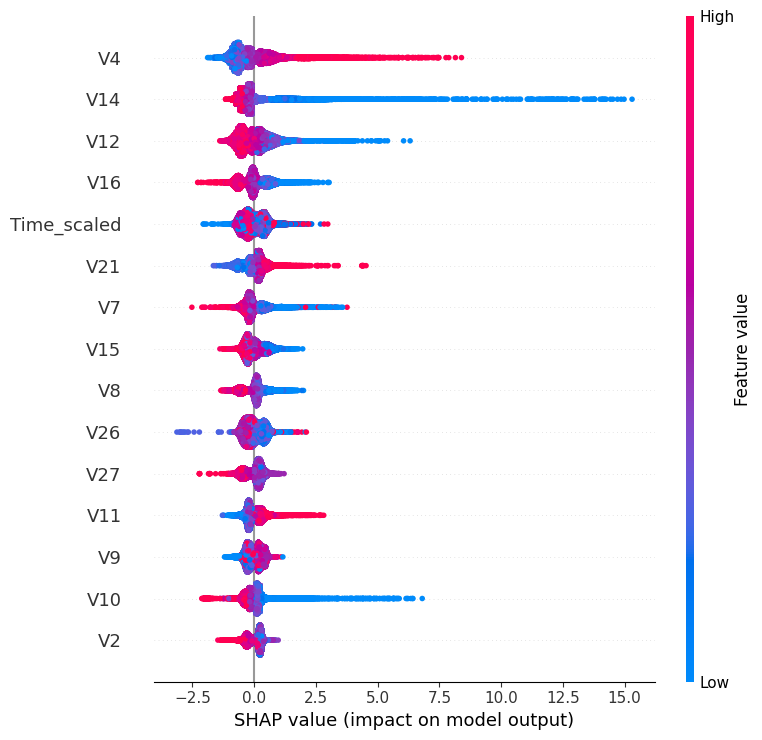

In [ ]:
# 5. Global explanation (Direction & distribution)
shap.summary_plot(
    shap_values_class1,
    X_explain,
    max_display=15
)

---

**🔍 Interpretation of the SHAP Summary Plot**

This plot reveals how each feature influences the LightGBM model’s prediction of fraudulent transactions, both in terms of **importance** and **direction of impact**.

1. **Feature Importance Ranking**
- The features are ranked top-to-bottom by their **mean absolute SHAP value**, which reflects how much each feature contributes to the model’s output across all samples.
- **V4, V14, V12, and V16** are the most influential features, meaning they consistently have a strong effect on the model’s prediction.

2. **Directional Impact of Feature Values**
- The **x-axis** shows the SHAP value — how much a feature pushes the prediction toward fraud (positive SHAP value) or non-fraud (negative SHAP value).
- The **color gradient** (blue to red) represents the actual value of the feature for each instance:
  - **Red dots** = high feature values
  - **Blue dots** = low feature values

This explains:
- **V4:** Low values (blue) tend to push the prediction toward fraud (positive SHAP), while high values (red) push toward non-fraud.
- **V14:** High values (red) are associated with higher SHAP values, indicating a stronger push toward fraud.
- **Time_scaled:** Shows a mix — both low and high values can push the prediction in either direction, suggesting temporal patterns in fraud behavior.

3. **Feature Behavior Across Samples**
- Each dot is a single prediction instance. The spread of dots along the x-axis shows how variable the feature’s impact is across different transactions.
- Features like **V4 and V14** have a wide horizontal spread, meaning their influence varies significantly depending on the transaction.

4. **Low-Impact Features**
- Features like **V2, V10, and V9** appear at the bottom with narrow SHAP distributions, indicating they have minimal influence on the model’s decisions.

---


In [ ]:
# 6. Local explanation - Individual fraud case
# Picking a fraud that was correctly detected
fraud_cases = X_test[y_test == 1]

# Pick one example (first fraud)
fraud_idx = fraud_cases.index[0]

# Pick a fraud with high predicted probability
fraud_probs = lgbm.predict_proba(fraud_cases)[:, 1]
fraud_idx = fraud_cases.index[fraud_probs.argmax()]

# Compute prediction for the transaction
fraud_sample = X_explain.loc[[fraud_idx]]

fraud_proba = lgbm.predict_proba(fraud_sample)[:, 1][0]
print(f"Predicted fraud probability: {fraud_proba:.3f}")
print(f"Decision threshold: {threshold}")


Predicted fraud probability: 1.000
Decision threshold: 2.753359128476401e-05


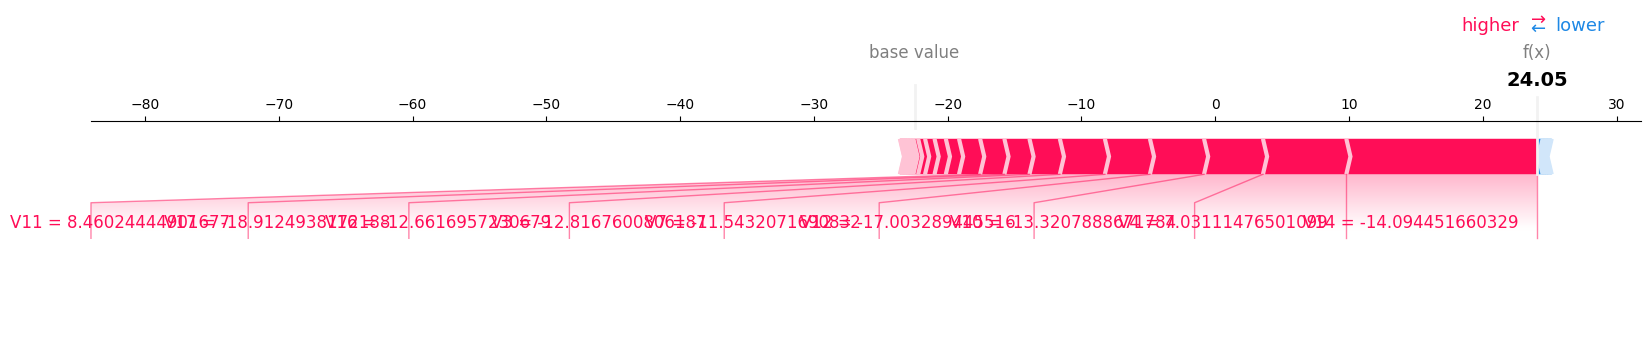

In [ ]:
# Generating a SHAP force plot
shap.force_plot(
    explainer.expected_value,
    shap_values[X_explain.index.get_loc(fraud_idx)],
    fraud_sample,
    matplotlib=True
)

---

**🔍 SHAP Force Plot Interpretation**

**🧠 What the Plot Shows**

- **Base Value:** The model’s average prediction before considering any feature values.
- **f(x) = 24.05:** The final prediction for this specific instance.
- **Feature Contributions:**
  - Features pushing the prediction **higher** (toward fraud) are shown in **red**.
  - Features pushing the prediction **lower** (toward non-fraud) are shown in **blue**.
  - The length of each segment reflects the **magnitude** of the feature’s impact.

**🔎 Key Feature Effects**

- **V14 (-14.09):** Strongly pushes the prediction downward, suggesting this feature value is associated with non-fraudulent behavior.
- **V10 (21.54), V7 (18.91), V9 (17.00), V6 (12.82):** These features significantly increase the prediction, indicating their values are strongly associated with fraudulent behavior in this instance.
- **V4 (3.01):** Has a small positive contribution.
- **V11, V3, V2:** Also contribute positively, but with smaller impact compared to V10 and V7.

### 📈 Interpretation Summary

This plot explains **why** the model predicted a value of 24.05 for this transaction. It shows that although **V14** strongly argued against fraud, the combined influence of **V10, V7, V9, and V6** outweighed it, leading to a high fraud prediction. This kind of visualization is crucial for understanding individual decisions and building trust in the model’s behavior.

---



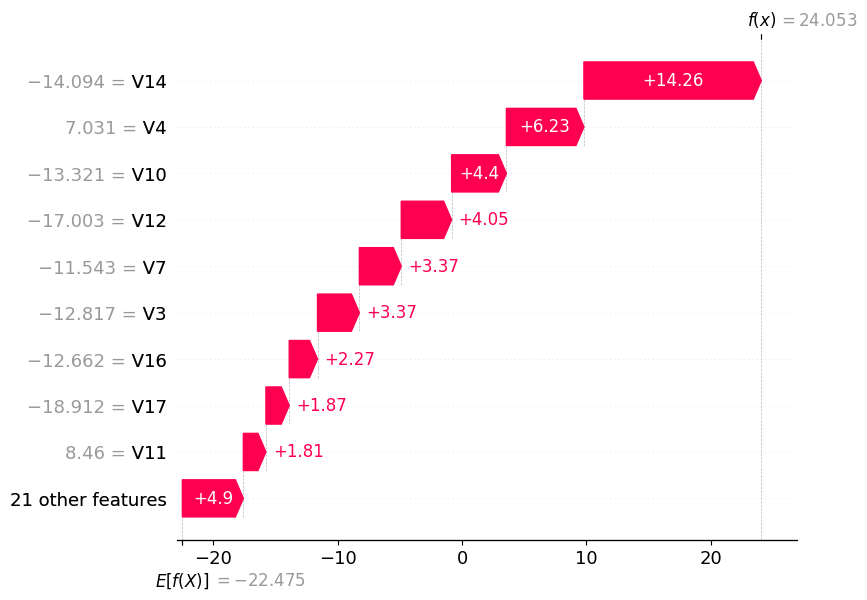

In [ ]:
# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[X_explain.index.get_loc(fraud_idx)],
        base_values=explainer.expected_value,
        data=fraud_sample.values[0],
        feature_names=X_explain.columns
    )
)

***Next Step***
- **Model Deployment**
